# VisDrone Object Detection dataset

Follow this notebook to prepare VisDrone dataset.

**Description:**
- The VisDrone source dataset is containing 10,209 static RGB images (6,471 for training, 548 for validation and 3,190 for testing) captured by drone platforms in different places at different height.

**Annotations:**
- bbox_left, bbox_top, bbox_width, bbox_height, score, object_category, truncation, occlusion
- bounding box in annotation in xywh format

**Source objects categories:**
- ignored regions (0), pedestrian (1), people (2), bicycle (3), car (4), van (5), truck (6), tricycle (7), awning-tricycle (8), bus (9), motor (10), others (11)


**Table of content:**

0. Init - imports and data download
1. Data annotation cleaning
2. Data transformation
3. Data visualization


## 0. Init - imports and data download

Download trainset, valset and testset-dev .zip files from [aiskyeye webpage](http://aiskyeye.com/download/object-detection-2/) and extract them to data directory:
- trainset to `data/source/VisDrone-ObjDet/train`,
- valset to `data/source/VisDrone-ObjDet/validate`,
- testset-dev to `data/source/VisDrone-ObjDet/test`.

After extract data directory should look like this:
```
data
└───source
    └───VisDrone-ObjDet
        ├───test
        │   ├───annotations
        │   └───images
        ├───train
        │   ├───annotations
        │   └───images
        └───validate
            ├───annotations
            └───images
```

In [1]:
# Uncomment below two lines to reload imported packages (in case of modifying them)
# %load_ext autoreload
# %autoreload 2

# Imports
import os
import random

from prj_utils.consts import ROOT_DIR
from data_processing.annotation_processing import clean_annotations_from_files
from data_processing.annotation_processing import from_xywh_to_xywhn_format
from data_processing.image_processing import copy_annotated_images, get_brightness_stats, get_number_of_objects_stats
from data_processing.image_processing import plot_xywhn_annotated_image_from_file
from random import sample

# Consts
TRAIN_DIR = f'{ROOT_DIR}/data/source/VisDrone-ObjDet/train'
VAL_DIR = f'{ROOT_DIR}/data/source/VisDrone-ObjDet/validate'
TEST_DIR = f'{ROOT_DIR}/data/source/VisDrone-ObjDet/test'

TRAIN_PROCESSED_DIR = f'{ROOT_DIR}/data/processed/VisDrone-ObjDet/train'
VAL_PROCESSED_DIR = f'{ROOT_DIR}/data/processed/VisDrone-ObjDet/validate'
TEST_PROCESSED_DIR = f'{ROOT_DIR}/data/processed/VisDrone-ObjDet/test'

VISDRONE_ANNOTATION_HEADER = ['x_left', 'y_top', 'width', 'height', 'score', 'class', 'trunc', 'occlusion']
PEOPLE_CLASSES = ['1', '2']
NEW_CLASS = '0'

In [2]:
print('Source dataset number of images:')
print('Train size:', len(os.listdir(f'{TRAIN_DIR}/annotations')))
print('Validate size:', len(os.listdir(f'{VAL_DIR}/annotations')))
print('Test size', len(os.listdir(f'{TEST_DIR}/annotations')))

Source dataset number of images:
Train size: 6471
Validate size: 548
Test size 1610


## 1. Data annotation cleaning
- Save labels without people to `data/processed` directory and convert people labels to new given class = '0'.

In [3]:
clean_annotations_from_files(f'{TRAIN_DIR}/annotations',
                             f'{TRAIN_PROCESSED_DIR}/annotations',
                             VISDRONE_ANNOTATION_HEADER,
                             PEOPLE_CLASSES, NEW_CLASS)

clean_annotations_from_files(f'{VAL_DIR}/annotations',
                             f'{VAL_PROCESSED_DIR}/annotations',
                             VISDRONE_ANNOTATION_HEADER,
                             PEOPLE_CLASSES, NEW_CLASS)

clean_annotations_from_files(f'{TEST_DIR}/annotations',
                             f'{TEST_PROCESSED_DIR}/annotations',
                             VISDRONE_ANNOTATION_HEADER,
                             PEOPLE_CLASSES, NEW_CLASS)

In [4]:
print('Train size only with people annotations:', len(os.listdir(f'{TRAIN_PROCESSED_DIR}/annotations')))
print('Validate size only with people annotations:', len(os.listdir(f'{VAL_PROCESSED_DIR}/annotations')))
print('Test size only with people annotations:', len(os.listdir(f'{TEST_PROCESSED_DIR}/annotations')))

Train size only with people annotations: 5684
Validate size only with people annotations: 531
Test size only with people annotations: 1267


## 2. Data transformation
- Convert data to YOLO format
- Image transformations

### 2.1 Convert annotations to YOLO format

Prepare dataset.yaml in data dir:
```yaml
path: ../data/processed/VisDrone-ObjDet  # dataset root dir
train: train/images
val: validate/images
test:  test/images

# Classes
nc: 1  # number of classes
names: ['person']
```

Yolo format:
- One *.txt file per image (if no objects in image, no *.txt file is required).
- One row per object.
- Each row is `class x_center y_center scaled_width scaled_height` format, separated by space.
- Box coordinates must be in normalized from 0 to 1. If your boxes are in pixels, divide x_center and width by image width, and y_center and height by image height.
- Bounding box in annotation in xywhn format
- Class numbers are zero-indexed (start from 0).

More about yolo format data [here](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data#11-create-datasetyaml).

In [5]:
from_xywh_to_xywhn_format(f'{TRAIN_PROCESSED_DIR}/annotations',
                          f'{TRAIN_PROCESSED_DIR}/labels',
                          f'{TRAIN_DIR}/images',
                          VISDRONE_ANNOTATION_HEADER)

from_xywh_to_xywhn_format(f'{VAL_PROCESSED_DIR}/annotations',
                          f'{VAL_PROCESSED_DIR}/labels',
                          f'{VAL_DIR}/images',
                          VISDRONE_ANNOTATION_HEADER)

from_xywh_to_xywhn_format(f'{TEST_PROCESSED_DIR}/annotations',
                          f'{TEST_PROCESSED_DIR}/labels',
                          f'{TEST_DIR}/images',
                          VISDRONE_ANNOTATION_HEADER)

### 2.2 Image transformations
- Copy images only with annotations from source directory to processed.

After this step processed data directory should look like this:

```
data
└───processed
    └───VisDrone-ObjDet
        ├───test
        │   ├───annotations
        │   ├───images
        │   └───labels
        ├───train
        │   ├───annotations
        │   ├───images
        │   └───labels
        └───validate
            ├───annotations
            ├───images
            └───labels
```

In [6]:
copy_annotated_images(f'{TRAIN_DIR}/images',
                      f'{TRAIN_PROCESSED_DIR}/labels',
                      f'{TRAIN_PROCESSED_DIR}/images')

copy_annotated_images(f'{VAL_DIR}/images',
                      f'{VAL_PROCESSED_DIR}/labels',
                      f'{VAL_PROCESSED_DIR}/images')

copy_annotated_images(f'{TEST_DIR}/images',
                      f'{TEST_PROCESSED_DIR}/labels',
                      f'{TEST_PROCESSED_DIR}/images')

In [7]:
print('Train images size only with people annotations:', len(os.listdir(f'{TRAIN_PROCESSED_DIR}/images')))
print('Validate images size only with people annotations:', len(os.listdir(f'{VAL_PROCESSED_DIR}/images')))
print('Test images size only with people annotations:', len(os.listdir(f'{TEST_PROCESSED_DIR}/images')))

Train images size only with people annotations: 5684
Validate images size only with people annotations: 531
Test images size only with people annotations: 1267


## 3. Dataset visualization
- Dataset stats
- Data annotation visualization - example images

After whole data processing, dataset should contain different resolution images only with annotated people. It should be around:
- ~5.5k images for train dataset,
- ~0.5k for validate set,
- and ~1k for test set.
- and ~1k for test set.

### 3.1 Dataset stats
Show stats by:
- number of objects in the images
- average lightness

array([[<AxesSubplot:title={'center':'number of objects'}>]], dtype=object)

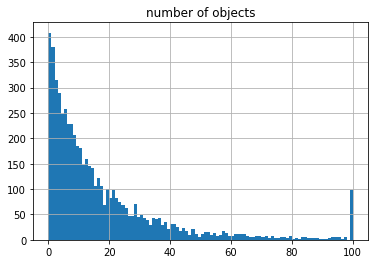

In [8]:
# By number of objects
max_people_limit = 100
number_of_people_stats = get_number_of_objects_stats(TRAIN_PROCESSED_DIR + '/annotations')
number_of_people_stats[number_of_people_stats['number of objects'] > max_people_limit] = max_people_limit
number_of_people_stats[number_of_people_stats['number of objects'] <= max_people_limit].hist(column='number of objects',
                                                                                             bins=max_people_limit)

array([[<AxesSubplot:title={'center':'avg brightness'}>]], dtype=object)

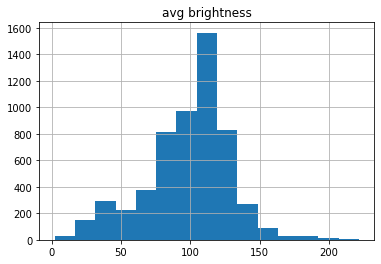

In [9]:
# By lightness
avg_lightness = get_brightness_stats(TRAIN_PROCESSED_DIR + '/images')
avg_lightness.hist(column='avg brightness', bins=15)

## 3.2 Example images

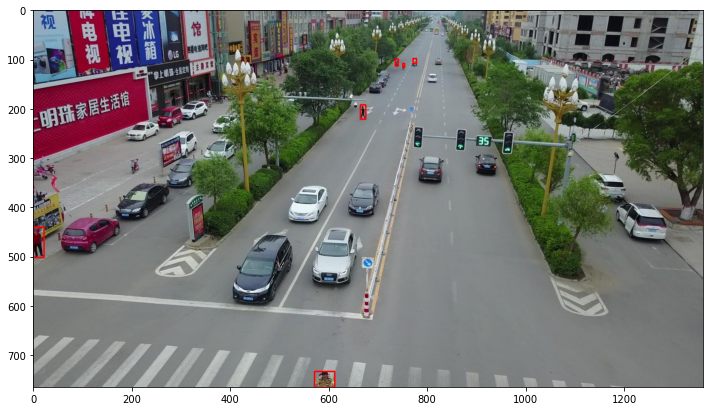

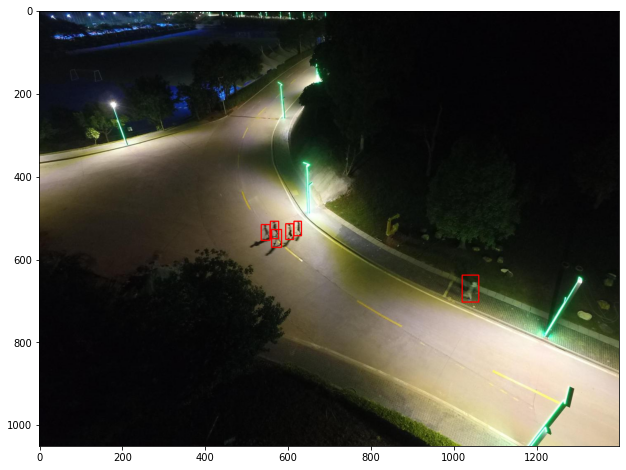

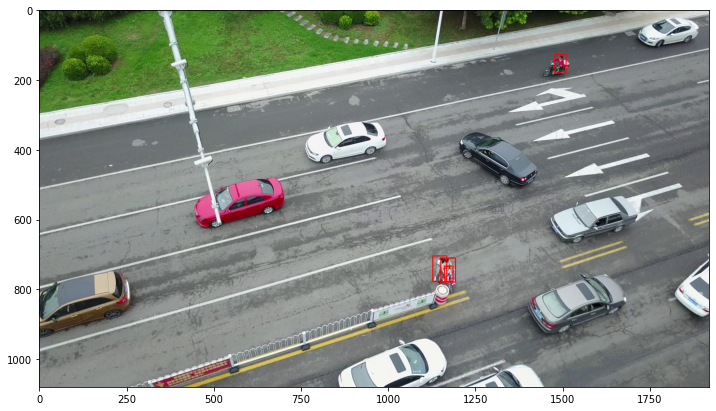

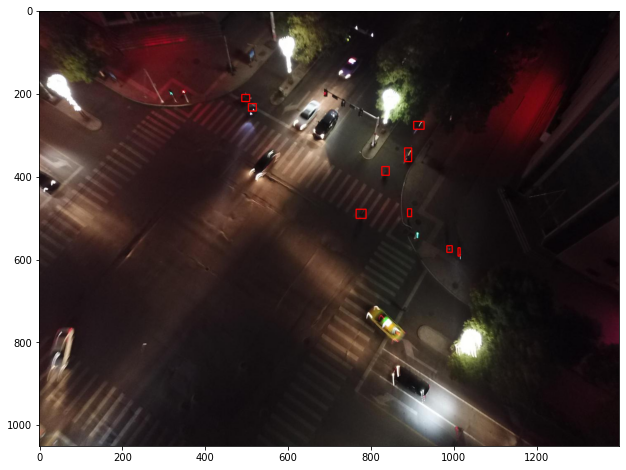

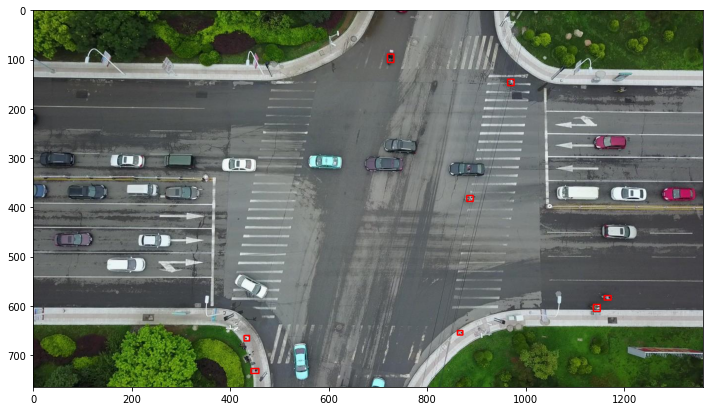

In [10]:
random.seed(1)
for filename in sample(os.listdir(f'{TRAIN_PROCESSED_DIR}/images'), 5):
    plot_xywhn_annotated_image_from_file(f'{TRAIN_PROCESSED_DIR}/images/{filename.split(".")[0]}.jpg',
                                         f'{TRAIN_PROCESSED_DIR}/labels/{filename.split(".")[0]}.txt')
